<center><h1>Sport Activities Image and Video Classiﬁcation</h1></center>

## 1. Transfer Learning for Video Classiﬁcation

Import packages

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import shutil
import cv2

### (d) Data Exploration and Pre-processing

#### ii. Split the training, validation, and test sets

In [4]:
sports_list = ['baseball', 'fencing', 'volleyball', 'basketball', 'tennis']
folder_path = '../data/Sport Images'

In [5]:
# delete the directory if already exist
for set in ['train', 'val', 'test']:
    set_path = os.path.join(folder_path, set)
    if os.path.exists(set_path):
        shutil.rmtree(set_path)

for sports in sports_list:
    img_path = os.path.join(folder_path, sports)
    filenames = os.listdir(img_path)
    # shuffle the filenames
    random.shuffle(filenames)
    # get images count for each set
    num_train = math.ceil(0.7 * len(filenames))
    num_val = math.ceil(0.15 * len(filenames))
    num_test = len(filenames) - num_train - num_val
    for i, filename in enumerate(filenames):
        # determine train/val/test folder based on the index
        if i < num_train:
            set_dir = 'train'
        elif i < num_train + num_val:
            set_dir = 'val'
        else:
            set_dir = 'test'
        set_dir_path = os.path.join(folder_path, set_dir, sports)
        if not os.path.exists(set_dir_path):
            os.makedirs(set_dir_path)
        # copy the image file to the folder
        src_path = os.path.join(img_path, filename)
        new_path = os.path.join(set_dir_path, filename)
        shutil.copyfile(src_path, new_path)

#### iii. Resize the images

In [6]:
size = (224, 224)
for set in ['train', 'val', 'test']:
  set_path = os.path.join(folder_path, set)
  for sport in sports_list:
    sport_path = os.path.join(set_path, sport)
    for filename in os.listdir(sport_path):
      img_path = os.path.join(sport_path, filename)
      img = cv2.imread(img_path)
      if img is not None:
        # resize the image with original ratio
        h, w = img.shape[:2]
        if h > w:
          new_h = size[0]
          new_w = int(w * new_h / h)
        else:
          new_w = size[1]
          new_h = int(h * new_w / w)
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        # zero-pad the image to match the size
        top_pad = (size[0] - new_h) // 2
        bottom_pad = size[0] - new_h - top_pad
        left_pad = (size[1] - new_w) // 2
        right_pad = size[1] - new_w - left_pad
        img = cv2.copyMakeBorder(img, top_pad, bottom_pad, left_pad, right_pad, 
                                 cv2.BORDER_CONSTANT, value=[0, 0, 0])
        cv2.imwrite(img_path, img)

In [7]:
train_num = 0
val_num = 0
test_num = 0
for sports in sports_list:
    train_sports_path = os.path.join(folder_path + '/train', sports)
    train_num += len(os.listdir(train_sports_path))
    val_sports_path = os.path.join(folder_path + '/val', sports)
    val_num += len(os.listdir(val_sports_path))
    test_sports_path = os.path.join(folder_path + '/test', sports)
    test_num += len(os.listdir(test_sports_path))
print(train_num, val_num, test_num)

2298 495 487


### (e) Transfer Learning for Image Classiﬁcation

#### ii. Image augmentation

Found 2298 files belonging to 5 classes.


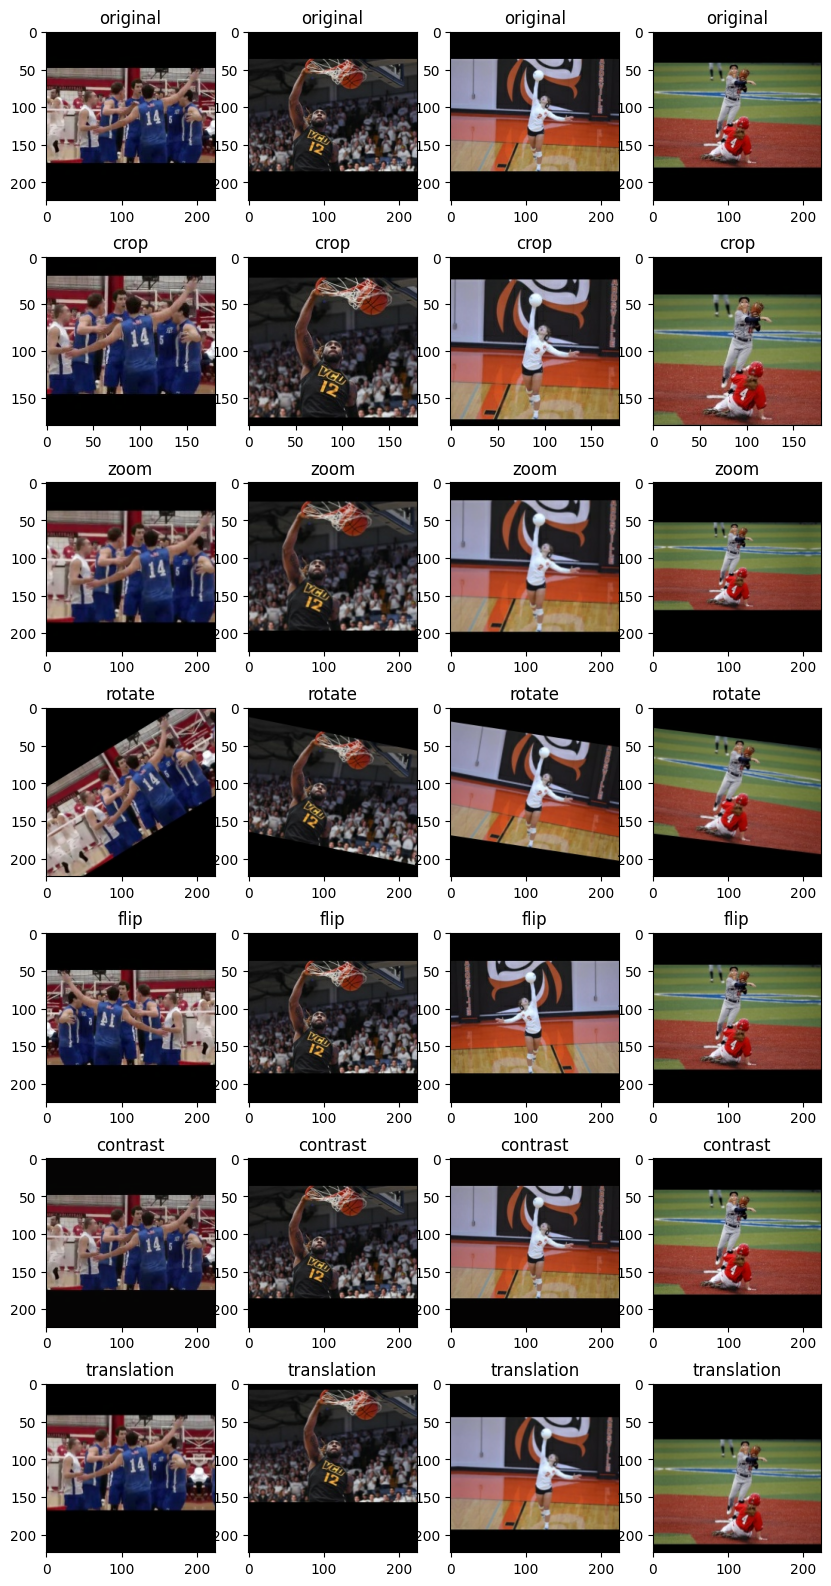

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

train_dir = folder_path + '/train'

crop = layers.RandomCrop(180, 180)
zoom = layers.RandomZoom(0.2)
rotate = layers.RandomRotation(0.1)
flip = layers.RandomFlip('horizontal')
contrast = layers.RandomContrast(0.2)
translation = layers.RandomTranslation(height_factor=0.2, width_factor=0.2)

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    )

# Visualize images augmentations
fig, ax = plt.subplots(7, 4, figsize=(10,20))
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # crop
        ax[1][i].imshow(crop(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("crop")
        # zoom
        ax[2][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("zoom")
        # rotate
        ax[3][i].imshow(rotate(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("rotate")
        # flip
        ax[4][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[4][i].set_title("flip")
        # contrast
        ax[5][i].imshow(contrast(images[i]).numpy().astype("uint8"))
        ax[5][i].set_title("contrast")
        # translation
        ax[6][i].imshow(translation(images[i]).numpy().astype("uint8"))
        ax[6][i].set_title("translation")
plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img

def random_augmentation(image):
    augmentations = [
        crop,
        zoom,
        rotate,
        flip,
        contrast,
        translation
    ]

    # shuffle the augmentations list and randomly choose one or more augmentation
    num_operations = random.randint(1, len(augmentations))
    random.shuffle(augmentations)  
    for i in range(num_operations):
        augmentation = augmentations[i]
        image = augmentation(image)

    return image

def augment_and_save_images(input_dir, proportion):
    for sports in sports_list:
        sport_path = os.path.join(input_dir, sports)
        image_paths = [os.path.join(sport_path, filename) for filename in os.listdir(sport_path) if not filename.endswith('.gif')]
        num_images_to_augment = int(len(os.listdir(sport_path)) * proportion)
        for _ in range(num_images_to_augment):
            random_image_path = random.choice(image_paths)
            # prevent augmenting the same image multiple times
            image_paths.remove(random_image_path)  
            image = load_img(random_image_path)
            image = img_to_array(image)

            augmented_image = random_augmentation(image)
            augmented_image = array_to_img(augmented_image)

            file_name_without_ext, file_ext = os.path.splitext(os.path.basename(random_image_path))
            output_image_name = f"{file_name_without_ext}_augmented{file_ext}"
            output_image_path = os.path.join(os.path.dirname(random_image_path), output_image_name)

            save_img(output_image_path, augmented_image)

# delete the image if it is already augmented 
for root, _, files in os.walk(train_dir):
    for filename in files:
        if (filename.endswith('_augmented.jpg') or filename.endswith('_augmented.jpeg') or
            filename.endswith('_augmented.png') or filename.endswith('_augmented.JPG')):
            file_path = os.path.join(root, filename)
            os.remove(file_path)

# augmented 20% of images from training set
augment_and_save_images(train_dir, 0.2)

#### iii. Build up layers

In [10]:
from tensorflow.keras import Model

def create_model(base_model, num_classes):
    base_model.trainable = False
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    # add ReLU activation in the last hidden layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    # add softmax
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

#### iv. Train the networks ResNet50, EfficientNetB0, and VGG16

In [11]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

train_dir = folder_path + '/train'
val_dir = folder_path + '/val'
test_dir = folder_path + '/test'

batch_size = 32

# load the image dataset from directories
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=batch_size, 
    shuffle=True
    )
val_dataset = image_dataset_from_directory(
    val_dir, 
    image_size=(224, 224), 
    batch_size=batch_size, 
    shuffle=True
    )
test_dataset = image_dataset_from_directory(
    test_dir, 
    image_size=(224, 224), 
    batch_size=batch_size, 
    shuffle=True
    )
num_classes = len(train_dataset.class_names)

resnet50_base = ResNet50(
    input_shape=(224, 224, 3), 
    include_top=False, 
    weights='imagenet'
    )
efficientnetb0_base = EfficientNetB0(
    input_shape=(224, 224, 3), 
    include_top=False,
     weights='imagenet'
     )
vgg16_base = VGG16(
    input_shape=(224, 224, 3), 
    include_top=False, 
    weights='imagenet'
    )

# create models using the base models
resnet50_model = create_model(resnet50_base, num_classes)
efficientnetb0_model = create_model(efficientnetb0_base, num_classes)
vgg16_model = create_model(vgg16_base, num_classes)

models = {'ResNet50': resnet50_model, 
          'EfficientNetB0': efficientnetb0_model, 
          'VGG16': vgg16_model}

early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                               restore_best_weights=True)

history_dict = {}
stopped_epochs = {}
for name, model in models.items():
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model_checkpoint = ModelCheckpoint(filepath=f'{name}_best_weights.h5',
                                       monitor='val_loss',
                                       mode='min',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       verbose=1)
    callbacks = [early_stopping, model_checkpoint]

    print(f"Training {name} model...")
    train_history = model.fit(train_dataset, 
                              validation_data=val_dataset, 
                              epochs=50, callbacks=callbacks)
    history_dict[name] = train_history
    stopped_epochs[name] = early_stopping.stopped_epoch
    print(f"{name} model training complete.\n")

Found 2756 files belonging to 5 classes.
Found 494 files belonging to 5 classes.
Found 487 files belonging to 5 classes.
Training ResNet50 model...
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.7652
Epoch 1: val_loss improved from inf to 0.47412, saving model to ResNet50_best_weights.h5
87/87 [==============================] - 13s 79ms/step - loss: 0.7214 - accuracy: 0.7652 - val_loss: 0.4741 - val_accuracy: 0.8259
Epoch 2/50
85/87 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9125
Epoch 2: val_loss improved from 0.47412 to 0.33539, saving model to ResNet50_best_weights.h5
87/87 [==============================] - 5s 54ms/step - loss: 0.2371 - accuracy: 0.9133 - val_loss: 0.3354 - val_accuracy: 0.8887
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9612
Epoch 3: val_loss did not improve from 0.33539
87/87 [==============================] - 5s 50ms/step - loss: 0.1209 - accuracy:

After I changed the value of shuffle from True to False, the accuracy improved greatly. The possible reasons could be that shuffle increases batch diversity and breaks correlation.

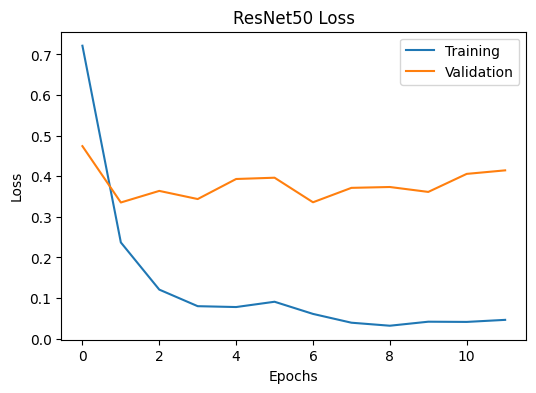

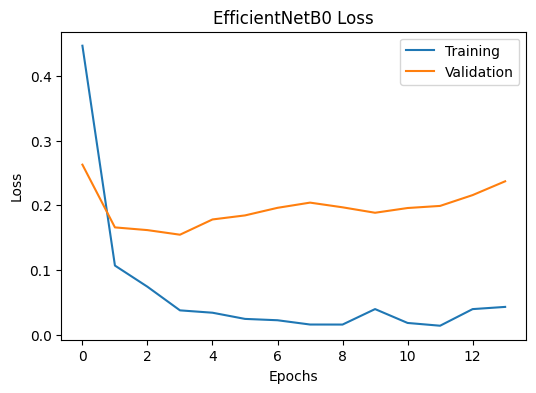

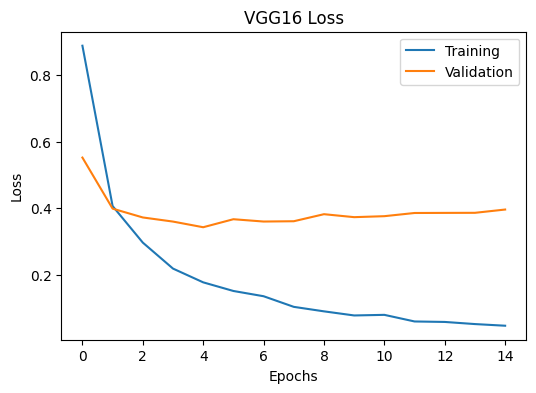

In [12]:
# plot the training and validation errors vs. epochs
def plot_training_error(history, model_name):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.show()

for name, history in history_dict.items():
    plot_training_error(history, name)

Unlike training loss that keep decreasing, the validation loss is decreasing first but increasing after, which could implies that the model is already overfitting the training data after a few epoch. 

#### v. Confusion Matrix, Precision, Recall, Accuracy, and F1 score

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model, dataset, model_name, class_names):
    preds_probs = []
    true_labels = []
    
    for x, y in dataset:
        preds_probs_batch = model.predict(x)
        preds_probs.extend(preds_probs_batch)
        true_labels.extend(y.numpy())
        
    preds_probs = np.array(preds_probs)
    true_labels = np.array(true_labels)
    
    preds = np.argmax(preds_probs, axis=-1)
    
    # save confusion matrix and classification report
    cm = confusion_matrix(true_labels, preds)
    cr = classification_report(true_labels, preds, target_names=class_names)

    return cm, cr

cm_train_dict = {}
cr_train_dict = {}
cm_test_dict = {}
cr_test_dict = {}
for name, model in models.items():
    # load the saved best weights
    best_weights_path = f'{name}_best_weights.h5'
    model.load_weights(best_weights_path)

    cm_train_dict[name], cr_train_dict[name] = evaluate_model(model, train_dataset, name, train_dataset.class_names)
    cm_test_dict[name], cr_test_dict[name] = evaluate_model(model, test_dataset, name, train_dataset.class_names)

1/1 [==============================] - 0s 488ms/step


Training results for ResNet50:
ResNet50 Confusion Matrix:


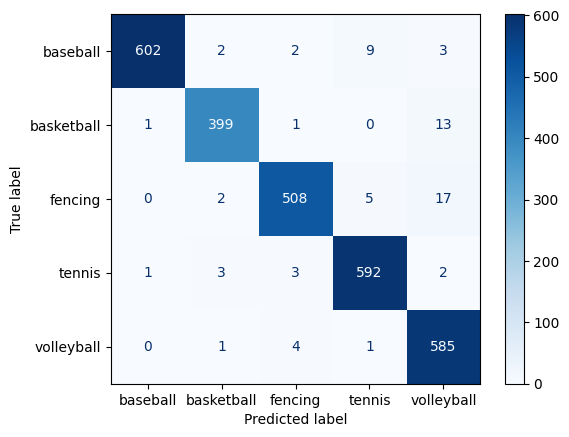

ResNet50 Classification Report:
              precision    recall  f1-score   support

    baseball       1.00      0.97      0.99       618
  basketball       0.98      0.96      0.97       414
     fencing       0.98      0.95      0.97       532
      tennis       0.98      0.99      0.98       601
  volleyball       0.94      0.99      0.97       591

    accuracy                           0.97      2756
   macro avg       0.98      0.97      0.97      2756
weighted avg       0.98      0.97      0.97      2756

Test results for ResNet50:
ResNet50 Confusion Matrix:


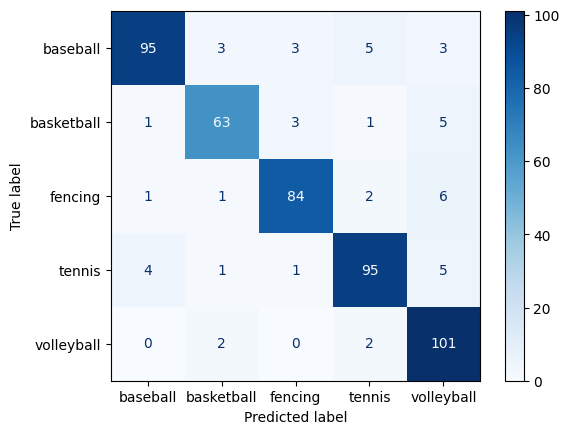

ResNet50 Classification Report:
              precision    recall  f1-score   support

    baseball       0.94      0.87      0.90       109
  basketball       0.90      0.86      0.88        73
     fencing       0.92      0.89      0.91        94
      tennis       0.90      0.90      0.90       106
  volleyball       0.84      0.96      0.90       105

    accuracy                           0.90       487
   macro avg       0.90      0.90      0.90       487
weighted avg       0.90      0.90      0.90       487

Training results for EfficientNetB0:
EfficientNetB0 Confusion Matrix:


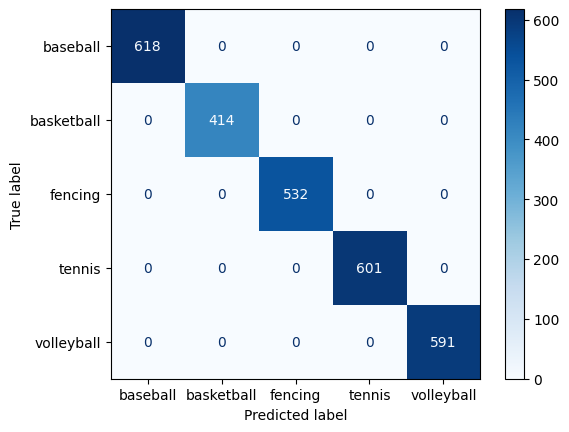

EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

    baseball       1.00      1.00      1.00       618
  basketball       1.00      1.00      1.00       414
     fencing       1.00      1.00      1.00       532
      tennis       1.00      1.00      1.00       601
  volleyball       1.00      1.00      1.00       591

    accuracy                           1.00      2756
   macro avg       1.00      1.00      1.00      2756
weighted avg       1.00      1.00      1.00      2756

Test results for EfficientNetB0:
EfficientNetB0 Confusion Matrix:


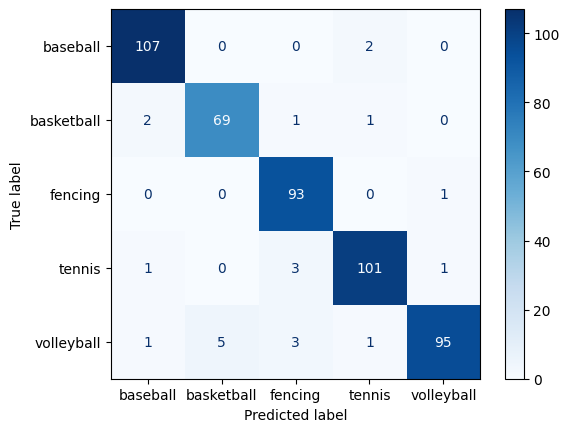

EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

    baseball       0.96      0.98      0.97       109
  basketball       0.93      0.95      0.94        73
     fencing       0.93      0.99      0.96        94
      tennis       0.96      0.95      0.96       106
  volleyball       0.98      0.90      0.94       105

    accuracy                           0.95       487
   macro avg       0.95      0.95      0.95       487
weighted avg       0.96      0.95      0.95       487

Training results for VGG16:
VGG16 Confusion Matrix:


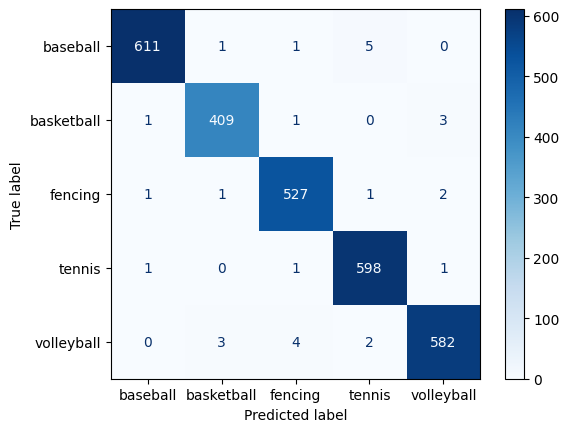

VGG16 Classification Report:
              precision    recall  f1-score   support

    baseball       1.00      0.99      0.99       618
  basketball       0.99      0.99      0.99       414
     fencing       0.99      0.99      0.99       532
      tennis       0.99      1.00      0.99       601
  volleyball       0.99      0.98      0.99       591

    accuracy                           0.99      2756
   macro avg       0.99      0.99      0.99      2756
weighted avg       0.99      0.99      0.99      2756

Test results for VGG16:
VGG16 Confusion Matrix:


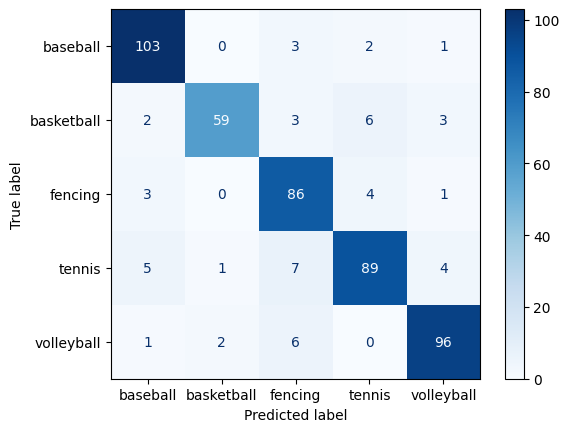

VGG16 Classification Report:
              precision    recall  f1-score   support

    baseball       0.90      0.94      0.92       109
  basketball       0.95      0.81      0.87        73
     fencing       0.82      0.91      0.86        94
      tennis       0.88      0.84      0.86       106
  volleyball       0.91      0.91      0.91       105

    accuracy                           0.89       487
   macro avg       0.89      0.88      0.89       487
weighted avg       0.89      0.89      0.89       487



In [14]:
for name, model in models.items(): 
    print(f'Training results for {name}:')
    print(f'{name} Confusion Matrix:')
    cm_train_display = ConfusionMatrixDisplay(confusion_matrix=cm_train_dict[name], 
                                        display_labels=train_dataset.class_names)
    cm_train_display.plot(values_format='d', cmap='Blues')
    plt.show()
    print(f'{name} Classification Report:')
    print(cr_train_dict[name])
    
    print(f'Test results for {name}:')
    print(f'{name} Confusion Matrix:')
    cm_test_display = ConfusionMatrixDisplay(confusion_matrix=cm_test_dict[name], 
                                             display_labels=train_dataset.class_names)
    cm_test_display.plot(values_format='d', cmap='Blues')
    plt.show()
    print(f'{name} Classification Report:')
    print(cr_test_dict[name])

Amongs all three pretrained models, EfficientNetB0 has the best test accuracy, following by ResNet50 and VGG16.

### (f) Video Classiﬁcation Using Moving Averages

#### i. Reuse the validation and test data and train the network.

In [15]:
# concatenate train, val, and test datasets
train_val_dataset = train_dataset.concatenate(val_dataset)
combined_dataset = train_val_dataset.concatenate(test_dataset)

# retrain the three models with all data
combined_history_dict = {}
for name, model in models.items():
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # set monitor to 'loss' as there is not validation set
    model_checkpoint = ModelCheckpoint(filepath=f'{name}_combined_best_weights.h5',
                                       monitor='loss',  
                                       mode='min',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       verbose=1)
    
    callbacks = [model_checkpoint]

    print(f"Training {name} model...")
    train_history = model.fit(combined_dataset, 
                              epochs=stopped_epochs[name]+1, 
                              callbacks=callbacks)
    combined_history_dict[name] = train_history
    print(f"{name} model training complete.\n")

    best_weights_path = f'{name}_combined_best_weights.h5'
    model.save_weights(best_weights_path)

Training ResNet50 model...
Epoch 1/12
118/119 [============================>.] - ETA: 0s - loss: 0.2804 - accuracy: 0.9137
Epoch 1: loss improved from inf to 0.28040, saving model to ResNet50_combined_best_weights.h5
119/119 [==============================] - 9s 45ms/step - loss: 0.2804 - accuracy: 0.9133
Epoch 2/12
118/119 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9475
Epoch 2: loss improved from 0.28040 to 0.15727, saving model to ResNet50_combined_best_weights.h5
119/119 [==============================] - 6s 47ms/step - loss: 0.1573 - accuracy: 0.9476
Epoch 3/12
118/119 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9676
Epoch 3: loss improved from 0.15727 to 0.09108, saving model to ResNet50_combined_best_weights.h5
119/119 [==============================] - 6s 45ms/step - loss: 0.0911 - accuracy: 0.9674
Epoch 4/12
118/119 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9662
Epoch 4: loss did not improve

#### ii. iii. Video preprocessing and classification

In [16]:
def extract_frames(video_path, L):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames//L, 1)
    frame_indices = np.linspace(0, total_frames - 1, num=L, dtype=int)
    frames = []

    for i in frame_indices:
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = video.read()

        if ret:
            frames.append(frame)

    video.release()
    return frames[:L]

def predict_on_video(model, frames, preprocess_function, input_size):
    preprocessed_frames = [preprocess_function(cv2.resize(frame, input_size)) for frame in frames]
    preprocessed_frames = np.stack(preprocessed_frames)
    probabilities = model.predict(preprocessed_frames)
    return np.mean(probabilities, axis=0)

final_models = {
    'ResNet50': {
        'model': resnet50_model,
        'preprocess_function': tf.keras.applications.resnet50.preprocess_input,
        'weights_path': 'ResNet50_combined_best_weights.h5'
    },
    'EfficientNetB0': {
        'model': efficientnetb0_model,
        'preprocess_function': tf.keras.applications.efficientnet.preprocess_input,
        'weights_path': 'EfficientNetB0_combined_best_weights.h5'
    },
    'VGG16': {
        'model': vgg16_model,
        'preprocess_function': tf.keras.applications.vgg16.preprocess_input,
        'weights_path': 'VGG16_combined_best_weights.h5'
    }
}

video_folder = my_dir + '/data/Sport Videos'
L = 100
input_size = (224, 224)
class_names = os.listdir(video_folder)
model_class_names = train_dataset.class_names
class_names.sort()
model_class_names.sort()

cm_dict = {}
cr_dict = {}
for model_name, model_data in final_models.items():
    print(f"\nEvaluating {model_name} model")
    model_data['model'].load_weights(model_data['weights_path'])

    y_true = []
    y_pred = []
    for actual_class, class_name in enumerate(class_names):
        class_folder = os.path.join(video_folder, class_name)
        for video_name in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_name)
            frames = extract_frames(video_path, L)
            avg_probabilities = predict_on_video(model_data['model'], 
                                                 frames, 
                                                 model_data['preprocess_function'], 
                                                 input_size)
            predicted_class = np.argmax(avg_probabilities)

            y_true.append(actual_class)
            y_pred.append(predicted_class)

    cm_dict[model_name] = confusion_matrix(y_true, y_pred)
    cr_dict[model_name] = classification_report(y_true, y_pred, target_names=model_class_names)


Evaluating ResNet50 model
4/4 [==============================] - 0s 31ms/step

Evaluating EfficientNetB0 model
4/4 [==============================] - 0s 20ms/step

Evaluating VGG16 model
4/4 [==============================] - 0s 37ms/step


#### iv. Confusion Matrix, Precision, Recall, Accuracy, and F1 score

ResNet50 Confusion Matrix:


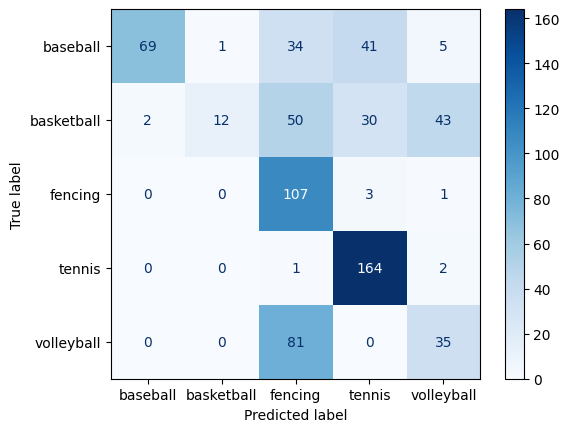

ResNet50 Classification Report:
              precision    recall  f1-score   support

    baseball       0.97      0.46      0.62       150
  basketball       0.92      0.09      0.16       137
     fencing       0.39      0.96      0.56       111
      tennis       0.69      0.98      0.81       167
  volleyball       0.41      0.30      0.35       116

    accuracy                           0.57       681
   macro avg       0.68      0.56      0.50       681
weighted avg       0.70      0.57      0.52       681

EfficientNetB0 Confusion Matrix:


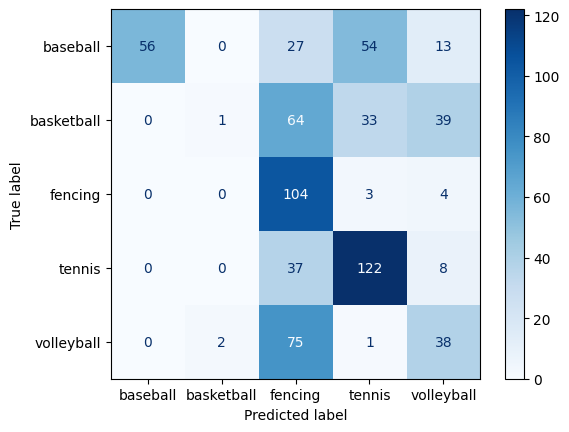

EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

    baseball       1.00      0.37      0.54       150
  basketball       0.33      0.01      0.01       137
     fencing       0.34      0.94      0.50       111
      tennis       0.57      0.73      0.64       167
  volleyball       0.37      0.33      0.35       116

    accuracy                           0.47       681
   macro avg       0.52      0.48      0.41       681
weighted avg       0.55      0.47      0.42       681

VGG16 Confusion Matrix:


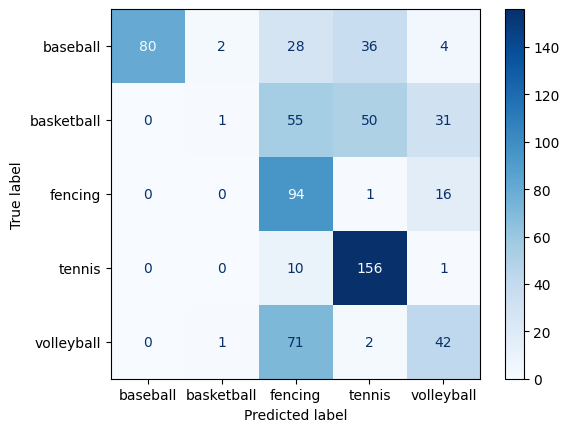

VGG16 Classification Report:
              precision    recall  f1-score   support

    baseball       1.00      0.53      0.70       150
  basketball       0.25      0.01      0.01       137
     fencing       0.36      0.85      0.51       111
      tennis       0.64      0.93      0.76       167
  volleyball       0.45      0.36      0.40       116

    accuracy                           0.55       681
   macro avg       0.54      0.54      0.48       681
weighted avg       0.56      0.55      0.49       681



In [17]:
for model_name, model_data in final_models.items():
    print(f'{model_name} Confusion Matrix:')
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_dict[model_name], 
                                        display_labels=model_class_names)
    cm_display.plot(values_format='d', cmap='Blues')
    plt.show()
    print(f'{model_name} Classification Report:')
    print(cr_dict[model_name])

ResNet50 has the best test accuracy in classifying videos, following by VGG16 and EfficientNetB0. All the three models have poor performance on classifying basketball videos. The possible reasons could be that basketball videos are significantly different from the basketball images. 

### References

https://www.geeksforgeeks.org/python-shutil-copyfile-method/

https://www.geeksforgeeks.org/image-resizing-using-opencv-python/

https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

https://www.tensorflow.org/tutorials/images/classification

https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

https://keras.io/api/layers/preprocessing_layers/

https://keras.io/guides/transfer_learning/

https://keras.io/api/callbacks/early_stopping/

https://keras.io/api/callbacks/model_checkpoint/

https://keras.io/examples/vision/video_classification/